# Modeling

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn import svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import warnings

%matplotlib inline

In [72]:
df = pd.read_csv('../dataset/preprocessed_data_classification_Z.csv', index_col=0)

### Baseline Accuracy

In [60]:
df.score.value_counts()

0    5100
1    1806
2     801
Name: score, dtype: int64

In [61]:
5100 / (5100 + 1806 + 801)

0.6617360840794083

In [62]:
1806 / (5100 + 1806 + 801)

0.23433242506811988

In [63]:
801 / (5100 + 1806 + 801)

0.10393149085247178

### Oversampling

Befor re-sampling:
0    5100
1    1806
2     801
Name: score, dtype: int64


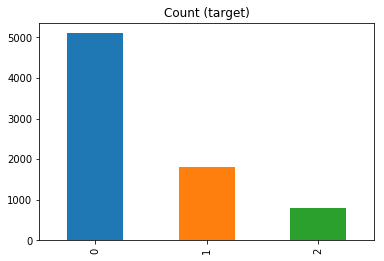

In [43]:
# Class count
count_class_0, count_class_1, count_class_2 = df.score.value_counts()

# Divide by class
df_class_0 = df[df['score'] == 0]
df_class_1 = df[df['score'] == 1]
df_class_2 = df[df['score'] == 2]

print('Befor re-sampling:')
print(df.score.value_counts())

df.score.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
2    5100
1    5100
0    5100
Name: score, dtype: int64


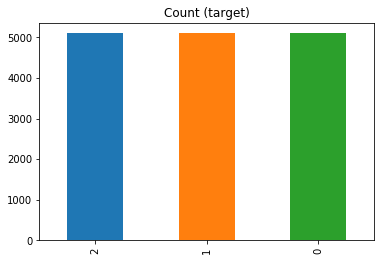

In [44]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_2_over = df_class_2.sample(count_class_0, replace=True)

df_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_over = pd.concat([df_over, df_class_2_over], axis=0)

print('Random over-sampling:')
print(df_over.score.value_counts())

df_over.score.value_counts().plot(kind='bar', title='Count (target)');

In [45]:
warnings.filterwarnings('ignore')

### Trees, knn, and logreg

In [47]:
random_forest = RandomForestClassifier()
extra_tree = ExtraTreeClassifier()
decision_tree = DecisionTreeClassifier()
bagged_tree = BaggingClassifier()
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [12]:
#multi_naive = MultinomialNB()

In [48]:
def scores(models):
    X = df.drop(columns=['score'])
    y = df['score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = StandardScaler()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [49]:
a = scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [50]:
a

,model,cross-val,train,test
0,"RandomForestClassifier(bootstrap=True, class_w...",0.610898,0.889792,0.601453
1,"ExtraTreeClassifier(class_weight=None, criteri...",0.566783,0.908478,0.574987
2,"DecisionTreeClassifier(class_weight=None, crit...",0.573182,0.908478,0.562013
3,"BaggingClassifier(base_estimator=None, bootstr...",0.616094,0.887370,0.602491
4,"LogisticRegression(C=1.0, class_weight=None, d...",0.652250,0.668858,0.655423
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.619893,0.714014,0.609237


In [51]:
pd.Series(y).value_counts()

2    5100
1    5100
0    5100
Name: score, dtype: int64

In [65]:
pd.Series(random_forest.predict(X_test_sc)).value_counts(1)

0    0.493072
1    0.301699
2    0.205229
dtype: float64

In [53]:
def pca_scores(models):
    X = df.drop(columns=['score'])
    y = df['score']
    
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    
    poly_col_names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_poly, columns=poly_col_names)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = PCA()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [66]:
b = pca_scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [67]:
pd.merge(a, b, on='model')

,model,cross-val_x,train_x,test_x,cross-val_y,train_y,test_y
0,"RandomForestClassifier(bootstrap=True, class_w...",0.610898,0.889792,0.601453,0.620245,0.898097,0.598858
1,"ExtraTreeClassifier(class_weight=None, criteri...",0.566783,0.908478,0.574987,0.541181,0.908478,0.550597
2,"DecisionTreeClassifier(class_weight=None, crit...",0.573182,0.908478,0.562013,0.542047,0.908478,0.542813
3,"BaggingClassifier(base_estimator=None, bootstr...",0.616094,0.887370,0.602491,0.611423,0.894637,0.578620
4,"LogisticRegression(C=1.0, class_weight=None, d...",0.652250,0.668858,0.655423,0.632873,0.719377,0.630514
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.619893,0.714014,0.609237,0.625776,0.715398,0.618578


In [54]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [57]:
model = XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: Found input variables with inconsistent numbers of samples: [7707, 3825]

In [23]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

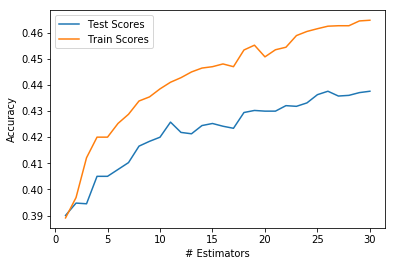

In [24]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [25]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

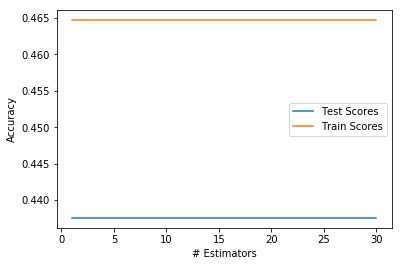

In [26]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [27]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

svc = svm.SVC(C=100)
svc.fit(X_train_sc, y_train)

y_pred = svc.predict(X_test_sc)

accuracy_score(y_test, y_pred)

0.8196850393700787

In [30]:
svc_param = {
    'C': [100, 10, 1, 0.1, 0.01],
    'kernel':['poly'],
    'degree': [2, 3, 4]
    
}

grid = GridSearchCV(
    svc,
    svc_param,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

### Neural Network

In [73]:
X = df.drop(columns=['score'])
y = to_categorical(df['score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)


In [74]:
model = Sequential()

# First hidden layer
model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(100, activation='relu'))

# For multiclass classification,
# 1 neuron
# softmax activation function
model.add(Dense(3, activation='softmax'))

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
results = model.fit(X_train_sc, y_train,
          epochs=15,
          validation_data=(X_test_sc, y_test))


Train on 5780 samples, validate on 1927 samples
Epoch 1/15
5780/5780 [==============================] - 1s 140us/step - loss: 0.8722 - acc: 0.6567 - val_loss: 0.8421 - val_acc: 0.6596
Epoch 2/15
5780/5780 [==============================] - 0s 61us/step - loss: 0.8130 - acc: 0.6621 - val_loss: 0.8383 - val_acc: 0.6492
Epoch 3/15
5780/5780 [==============================] - 0s 59us/step - loss: 0.7961 - acc: 0.6678 - val_loss: 0.8435 - val_acc: 0.6445
Epoch 4/15
5780/5780 [==============================] - 0s 59us/step - loss: 0.7854 - acc: 0.6702 - val_loss: 0.8482 - val_acc: 0.6554
Epoch 5/15
5780/5780 [==============================] - 0s 62us/step - loss: 0.7740 - acc: 0.6749 - val_loss: 0.8504 - val_acc: 0.6461
Epoch 6/15
5780/5780 [==============================] - 0s 58us/step - loss: 0.7645 - acc: 0.6763 - val_loss: 0.8505 - val_acc: 0.6450
Epoch 7/15
5780/5780 [==============================] - 0s 62us/step - loss: 0.7560 - acc: 0.6804 - val_loss: 0.8564 - val_acc: 0.6466
Epoch 

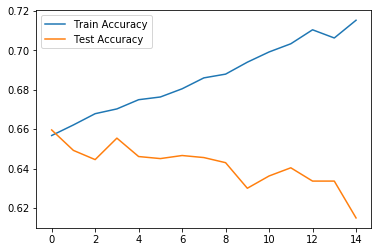

In [77]:
plt.plot(results.history['acc'], label='Train Accuracy')
plt.plot(results.history['val_acc'], label='Test Accuracy')
plt.legend()